In [11]:
import torch
import torch.optim as optim
import torch.utils
import torch.utils.data
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import csv
from utils.common import NeuralNet, fit
from scipy import stats, optimize

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

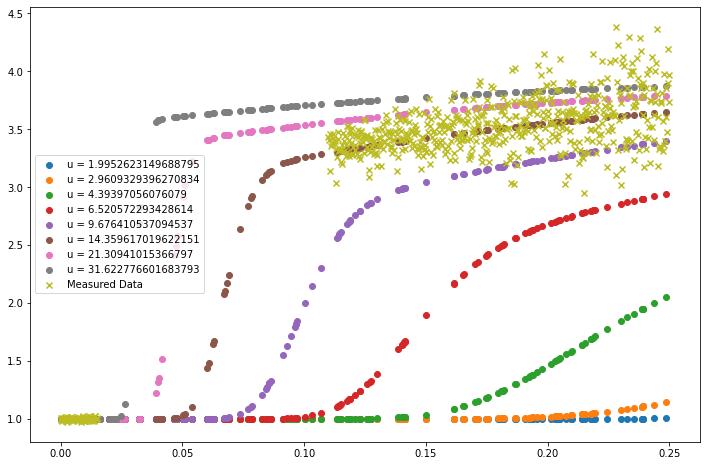

In [12]:
# Data Loading and visualisation
training_set = np.loadtxt("Data/TrainingData_Task4.txt", dtype=float)
measured_data = np.loadtxt("Data/MeasuredData_Task4.txt", dtype=float)

def get_plot(trainingdata, measureddata):
    u = trainingdata[:,1]
    for i in range(1,len(u)):
        if u[i-1] != u[i]:
            idx = i
            break
    # List containing all velocities
    velocities = []
    for i in range(0, len(u), idx):
        velocities.append(u[i])

    # For each velocity, 1 np.array is created containing the time and  corresponding to this velocity
    values_per_velocity = []
    for i in range(len(velocities)):
        value_for_velocity_i = np.empty((idx, 2))
        for j in range(len(u)):
            if (trainingdata[j,1] == velocities[i]):
                value_for_velocity_i[j%idx,0] = trainingdata[j,0]
                value_for_velocity_i[j%idx,1] = trainingdata[j,2]
        values_per_velocity.append(value_for_velocity_i)

        plt.figure(figsize=(12, 8))
    for i in range(len(values_per_velocity)):
        plt.scatter(values_per_velocity[i][:, 0], values_per_velocity[i][:, 1], marker='o', label='u = '+str(velocities[i]))
    plt.scatter(measureddata[:, 0], measureddata[:, 1], marker='x', label='Measured Data')
    #plt.scatter(Kalman_meas[:, 0], Kalman_meas[:, 1], marker='x', label='Kalman Measured Data')
    plt.legend()
get_plot(training_set, measured_data)

In [13]:
# Define data and labels to learn the map (t,u)-> T_f: network(t,u) = T_f
# Training Data
scale_t = MinMaxScaler()
scale_u = MinMaxScaler()
scale_T = MinMaxScaler()

scale_T_meas = MinMaxScaler()

t = scale_t.fit_transform(training_set[:,0].reshape(-1,1))
u = scale_u.fit_transform(training_set[:,1].reshape(-1,1))
T = scale_T.fit_transform(training_set[:,2].reshape(-1,1))

training_set = np.concatenate((t, u, T), 1)
training_set = torch.tensor(training_set).type(torch.float32)

# create a data loader to feed the netwkrm
x_train = torch.cat((training_set[:,0].reshape(-1,1), training_set[:,1].reshape(-1,1)), 1)
y_train = training_set[:,2].reshape(-1,1)

train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=128, shuffle=True) # RIGHT

# Measured data
measured_t = scale_t.transform(measured_data[:,0].reshape(-1, 1))
measured_T = scale_T.transform(measured_data[:,1].reshape(-1, 1))

measured_set = np.concatenate((measured_t, measured_T), 1)
measured_set = torch.tensor(measured_set).type(torch.float32)

In [14]:
# Model definition to learn the map network(t,u) = T_f
network = NeuralNet(input_dimension=2, # THE ONE I USE
                output_dimension=1,
                n_hidden_layers=7,
                neurons=40,
                regularization_param=0,
                regularization_exp=1,
                retrain_seed=128)

opt_type = "ADAM"
if opt_type == "ADAM":
    optimizer_cap = optim.Adam(network.parameters(), lr=0.001)

elif opt_type == "LBFGS":
    optimizer_cap = optim.LBFGS(network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)

else:
    raise ValueError("Optimizer not recognized")

n_epochs = 15000 #15000 RIGHT # 4000

history = fit(network, train_loader,n_epochs, optimizer_cap, p=2, verbose=False)

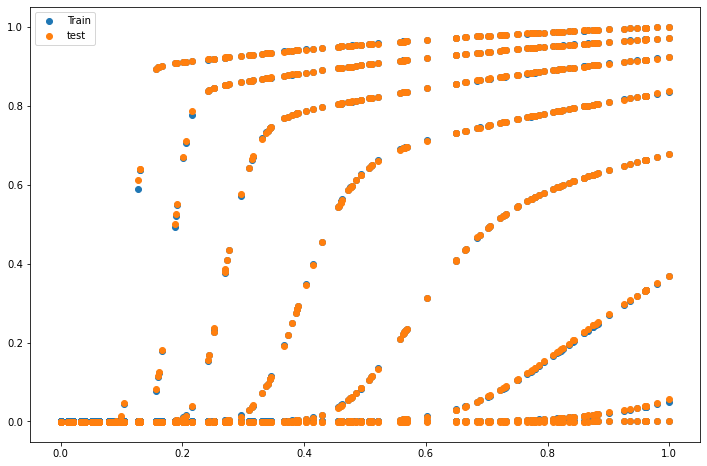

In [15]:
y_pred_on_data = network(x_train).detach()
plt.figure(figsize=(12, 8))
plt.scatter(x_train[:, 0], y_train[:, 0], marker='o', label='Train')
plt.scatter(x_train[:, 0], y_pred_on_data[:, 0], marker='o', label='test')
plt.legend()

In [16]:
n_iter = 1000
results = np.empty((n_iter, 3))
for i in range(n_iter):
    print(i)
    torch.manual_seed(i)
    
    rand = np.random.uniform(low=0, high=1, size=1)
    rand = rand
    y_opt = torch.tensor(rand, dtype=torch.float32).reshape(-1,1).requires_grad_()
    criterion = nn.MSELoss()

    #print(y_opt)

    #input_tensor = torch.cat((measured_set[:,0].reshape(len(measured_set[:,0]),1), y_opt), 1)
    #y_opt_tensor = y_opt * torch.ones(len(measured_set[:,0]))
    optimizer = optim.LBFGS([y_opt], lr=float(1e-5), max_iter=50000, max_eval=50000, history_size=100, line_search_fn="strong_wolfe", tolerance_change=1.0 * np.finfo(float).eps)
    #optimizer = optim.Adam([y_opt], lr=float(0.01))

    optimizer.zero_grad()
    cost = list([0])
    def closure():
        v_opt = y_opt.repeat(len(measured_set[:,0]),1)
        input_tensor = torch.cat([measured_set[:,0].reshape(len(measured_set[:,1]), 1), v_opt], dim=-1).requires_grad_()
        G = criterion(network(input_tensor), measured_set[:,1].reshape(len(measured_set[:,1]), 1))
        cost[0] = G
        G.backward()
        return G

    #print( y_opt)
    optimizer.step(closure=closure)

    results[i, 0] = cost[0].item()
    results[i, 1] = y_opt
    u_array = np.array(y_opt.detach().numpy()).reshape(-1,1)
    u = scale_u.inverse_transform(u_array)
    print(u)
    results[i, 2] = u #denormalise(y_opt, x_vel_range, x_vel_min).detach()

    # print(f'Seed = {i} with cost = {cost[0].item()}')
    # print("Infered Velocity:", denormalise(y_opt, x_vel_range, x_vel_min).detach())

result_min = results[np.argmin(results[:, 0]), :]
print(f'Infered Velocity: {result_min}')

0
[[15.281063]]
1
[[15.28427]]
2
[[15.284346]]
3
[[15.281866]]
4
[[15.283908]]
5
[[15.285927]]
6
[[15.281365]]
7
[[15.281669]]
8
[[15.281598]]
9
[[15.284413]]
10
[[15.280366]]
11
[[14.7987385]]
12
[[15.286308]]
13
[[15.280899]]
14
[[15.286898]]
15
[[15.285171]]
16
[[15.281596]]
17
[[14.5597515]]
18
[[15.281741]]
19
[[15.285214]]
20
[[15.284918]]
21
[[15.280853]]
22
[[15.285227]]
23
[[15.284238]]
24
[[15.281799]]
25
[[15.2843685]]
26


KeyboardInterrupt: 